# 3번 군집

In [35]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd

# 1. 데이터 불러오기
df = pd.read_csv("./dataset/cluster1_3.csv")

df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
df = df.sort_values(by=['VSL_ID', 'PORT_NAME', 'TIMESTAMP']).reset_index(drop=True)

# 결과 저장 리스트
rows_5h = []

# 30번째 시점 추출 (10분 단위 × 30 = 5시간)
for (vsl_id, port), group in df.groupby(['VSL_ID', 'PORT_NAME']):
    if len(group) >= 84:
        row_5h = group.iloc[83]  # 인덱스는 0부터 시작이므로 29번째가 30번째 행
        rows_5h.append(row_5h)

# 최종 데이터프레임
df_5h = pd.DataFrame(rows_5h).reset_index(drop=True)
print(df_5h.shape)
display(df_5h.head())
display(df_5h['PORT_NAME'].value_counts())

(93, 11)


,COUNTRY,PORT_NAME,VSL_ID,TIMESTAMP,COG,HEADING,LAT,LON,PORT_CD,CLUSTER_1,CLUSTER_2
0,JP,JPMKX,03bee488-e41d-3cda-84bf-f34e999be17c,2024-09-05 09:30:00,103.0,107.0,33.699650,132.068250,JPMKX,3,1
1,JP,JPUKB,0858e140-f23f-3a81-a60e-0148cd492f06,2024-12-12 23:20:00,155.0,155.0,33.547225,131.836852,JPUKB,3,6
2,JP,JPUKB,0d5f5858-b6b4-3c0e-8f08-2cc61c4a584d,2024-11-24 04:30:00,153.9,153.0,33.665185,131.768097,JPUKB,3,6
3,JP,JPSMZ,0dfd9ffa-d1a4-3482-931f-bb1e7810c47e,2024-12-07 22:20:00,152.8,151.0,33.208027,132.042362,JPSMZ,3,4
4,JP,JPTYO,0dfd9ffa-d1a4-3482-931f-bb1e7810c47e,2024-08-11 01:10:00,142.1,141.0,33.020553,132.174193,JPTYO,3,5


PORT_NAME
JPTYO    15
JPSMZ    14
JPYOK    14
JPUKB    13
JPKIJ    11
JPOSA    11
JPNGO     5
JPYKK     4
JPMKX     3
JPWAK     3
Name: count, dtype: int64

In [15]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [17]:
# 1. 항구 전체 데이터 불러오기
ports = pd.read_csv('./dataset/ports_final.csv')

# 2. 선택할 일본 항구 코드 리스트
target_ports = [
    "JPMKX", "JPYKK", "JPWAK", "JPKIJ", "JPSMZ", "JPYOK",
    "JPUKB", "JPTYO", "JPNGO", "JPOSA"
]

# 3. target_ports에 해당하는 항구만 필터링
filtered_df = ports[ports['PORT_CD'].isin(target_ports)].reset_index(drop=True)

# 4. 파일로 저장
filtered_df.to_csv("./dataset/cluster_3_selected_ports.csv", index=False)
print("✅ 저장 완료: cluster_3_selected_ports.csv")

✅ 저장 완료: cluster_3_selected_ports.csv


In [22]:
# 군집화 기준 피처: 위도(LAT), 경도(LON)
X = filtered_df[['LOC_LAT', 'LOC_LON']]

# KMeans 군집화 (클러스터 수는 elbow method 등으로 결정 가능)
kmeans = KMeans(n_clusters=2, random_state=42)
filtered_df['PORT_CLUSTER'] = kmeans.fit_predict(X)

# 결과 저장
filtered_df.to_csv("cluster_3_ports.csv", index=False)
print("✅ 재군집화 완료: cluster_3_reclustered_ports.csv")
filtered_df

✅ 재군집화 완료: cluster_3_reclustered_ports.csv


,PORT_CD,LOC_LAT,LOC_LON,PORT_CLUSTER
0,JPMKX,34.000000,133.530000,1
1,JPYKK,34.950000,136.620000,1
2,JPWAK,34.230000,135.170000,1
3,JPKIJ,37.943200,139.200100,0
4,JPSMZ,35.000000,138.500000,0
5,JPYOK,35.420000,139.620000,0
6,JPUKB,34.670000,135.180000,1
7,JPTYO,35.580000,139.780000,0
8,JPNGO,35.109095,136.872277,1
9,JPOSA,34.660000,135.480000,1


In [25]:
# PORT_CD (ports_df) ↔ PORT_NAME (cluster_df) 기준으로 병합
cluster_df = pd.read_csv('./dataset/cluster1_3.csv')
merged_df = cluster_df.merge(filtered_df, left_on='PORT_NAME', right_on='PORT_CD', how='left')
df = merged_df[['PORT_NAME','VSL_ID','TIMESTAMP','LAT','LON','COG','HEADING', 'PORT_CLUSTER']]
print(df.shape)
display(df.head())
print(df['PORT_CLUSTER'].value_counts())
df.to_csv('./dataset/cluster_3_v5.csv')

(25461, 8)


,PORT_NAME,VSL_ID,TIMESTAMP,LAT,LON,COG,HEADING,PORT_CLUSTER
0,JPUKB,e3364383-d027-3dd1-b915-60ac55ba8520,2024-12-16 01:50:00,35.062283,129.122033,133.0,138.0,1
1,JPUKB,e3364383-d027-3dd1-b915-60ac55ba8520,2024-12-16 02:00:00,35.039767,129.153183,127.0,132.0,1
2,JPUKB,e3364383-d027-3dd1-b915-60ac55ba8520,2024-12-16 02:10:00,35.017367,129.188583,127.0,131.0,1
3,JPUKB,e3364383-d027-3dd1-b915-60ac55ba8520,2024-12-16 02:20:00,34.984283,129.241000,126.0,127.0,1
4,JPUKB,e3364383-d027-3dd1-b915-60ac55ba8520,2024-12-16 02:30:00,34.970800,129.266517,122.0,125.0,1


PORT_CLUSTER
0    16064
1     9397
Name: count, dtype: int64


In [29]:
# 군집 번호 → 지역명(항구들) 매핑
cluster_to_region = {
    0: "East Japan (JPKIJ, JPTYO, JPYOK, JPSMZ)",
    1: "West Japan (JPUKB, JPOSA, JPWAK, JPYKK, JPNGO, JPMKX)"
}

# 매핑 적용
df2 = df.copy()
df2.loc[:, "PORT_CLUSTER"] = df2["PORT_CLUSTER"].map(cluster_to_region)
df2.to_csv("cluster_3_mapped_V2.csv", index=False, encoding='utf-8')
df2

,PORT_NAME,VSL_ID,TIMESTAMP,LAT,LON,COG,HEADING,PORT_CLUSTER
0,JPUKB,e3364383-d027-3dd1-b915-60ac55ba8520,2024-12-16 01:50:00,35.062283,129.122033,133.0,138.0,"West Japan (JPUKB, JPOSA, JPWAK, JPYKK, JPNGO,..."
1,JPUKB,e3364383-d027-3dd1-b915-60ac55ba8520,2024-12-16 02:00:00,35.039767,129.153183,127.0,132.0,"West Japan (JPUKB, JPOSA, JPWAK, JPYKK, JPNGO,..."
2,JPUKB,e3364383-d027-3dd1-b915-60ac55ba8520,2024-12-16 02:10:00,35.017367,129.188583,127.0,131.0,"West Japan (JPUKB, JPOSA, JPWAK, JPYKK, JPNGO,..."
3,JPUKB,e3364383-d027-3dd1-b915-60ac55ba8520,2024-12-16 02:20:00,34.984283,129.241000,126.0,127.0,"West Japan (JPUKB, JPOSA, JPWAK, JPYKK, JPNGO,..."
4,JPUKB,e3364383-d027-3dd1-b915-60ac55ba8520,2024-12-16 02:30:00,34.970800,129.266517,122.0,125.0,"West Japan (JPUKB, JPOSA, JPWAK, JPYKK, JPNGO,..."
...,...,...,...,...,...,...,...,...
25456,JPKIJ,65cb802a-fb34-3820-98d5-e69a7a82f5af,2024-08-07 22:30:00,37.993652,139.222055,160.9,161.0,"East Japan (JPKIJ, JPTYO, JPYOK, JPSMZ)"
25457,JPKIJ,65cb802a-fb34-3820-98d5-e69a7a82f5af,2024-08-07 22:40:00,37.978442,139.228393,165.3,165.0,"East Japan (JPKIJ, JPTYO, JPYOK, JPSMZ)"
25458,JPKIJ,65cb802a-fb34-3820-98d5-e69a7a82f5af,2024-08-07 22:50:00,37.971020,139.230802,183.0,176.0,"East Japan (JPKIJ, JPTYO, JPYOK, JPSMZ)"
25459,JPKIJ,65cb802a-fb34-3820-98d5-e69a7a82f5af,2024-08-07 23:00:00,37.969458,139.231280,338.9,143.0,"East Japan (JPKIJ, JPTYO, JPYOK, JPSMZ)"


In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from itertools import combinations
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [36]:
df = pd.read_csv("./dataset/cluster1_3.csv")

# PORT_NAME 기준으로 라벨 인코딩
le = LabelEncoder()
df['CLUSTER_2'] = le.fit_transform(df['CLUSTER_2'])

# 인코딩 결과 확인
print(df["CLUSTER_2"].value_counts())

CLUSTER_2
5    4776
9    4123
4    3888
0    3277
6    2819
3    2752
8    1297
2    1131
7     746
1     652
Name: count, dtype: int64


In [39]:
df['CLUSTER_2'].unique()

array([6, 8, 9, 3, 5, 4, 7, 1, 2, 0], dtype=int64)

In [44]:
# 시간 오름차순 정렬
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
df = df.sort_values(by=['VSL_ID', 'PORT_NAME', 'TIMESTAMP']).reset_index(drop=True)

# 결과 저장 리스트
rows_hours = []

# 시점 추출
for (vsl_id, port), group in df.groupby(['VSL_ID', 'PORT_NAME']):
    if len(group) >= 84:  # 5시간
        row = group.iloc[83]  # 5시간
        rows_hours.append(row)

# 최종 데이터프레임
df = pd.DataFrame(rows_hours).reset_index(drop=True)
print(df.shape)
display(df.head())
print(df['CLUSTER_2'].value_counts())

(93, 11)


,COUNTRY,PORT_NAME,VSL_ID,TIMESTAMP,COG,HEADING,LAT,LON,PORT_CD,CLUSTER_1,CLUSTER_2
0,JP,JPMKX,03bee488-e41d-3cda-84bf-f34e999be17c,2024-09-05 09:30:00,103.0,107.0,33.699650,132.068250,JPMKX,3,1
1,JP,JPUKB,0858e140-f23f-3a81-a60e-0148cd492f06,2024-12-12 23:20:00,155.0,155.0,33.547225,131.836852,JPUKB,3,6
2,JP,JPUKB,0d5f5858-b6b4-3c0e-8f08-2cc61c4a584d,2024-11-24 04:30:00,153.9,153.0,33.665185,131.768097,JPUKB,3,6
3,JP,JPSMZ,0dfd9ffa-d1a4-3482-931f-bb1e7810c47e,2024-12-07 22:20:00,152.8,151.0,33.208027,132.042362,JPSMZ,3,4
4,JP,JPTYO,0dfd9ffa-d1a4-3482-931f-bb1e7810c47e,2024-08-11 01:10:00,142.1,141.0,33.020553,132.174193,JPTYO,3,5


CLUSTER_2
5    15
4    14
9    14
6    13
0    11
3    11
2     5
8     4
1     3
7     3
Name: count, dtype: int64


In [47]:
features = ['LAT','LON','COG','HEADING']
target_cols = 'CLUSTER_2'
X = df[features]
y = df[target_cols]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# np.save("datasets/X_train_cluster3.npy", X_train)
# np.save("datasets/X_test_cluster3.npy", X_test)
# np.save("datasets/y_train_cluster3.npy", y_train)
# np.save("datasets/y_test_cluster3.npy", y_test)
# print("학습 및 테스트 데이터셋 저장 완료 !!!")

In [50]:
models = {
    'rf': RandomForestClassifier(random_state=42),
    #'lr': LogisticRegression(max_iter=1000, solver='liblinear'),
    'xgb': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    'lgbm': LGBMClassifier(random_state=42, verbose=-1),
    'knn': KNeighborsClassifier()
}

param_grids = {
    "rf": {
        "n_estimators": [100, 200],           # 트리 개수
        "max_depth": [10, None],              # 깊이 제한 유무
        "min_samples_split": [2, 5],          # 노드 분할 최소 샘플 수
        "class_weight": ['balanced']
    },
    "xgb": {
        "n_estimators": [100, 200],
        "max_depth": [4, 6],                  # 깊이 조절
        "learning_rate": [0.05, 0.1],
        "subsample": [0.8],                   # 샘플링 비율
        "colsample_bytree": [0.8],            # 피처 샘플링
        "use_label_encoder": [False],
        "eval_metric": ['mlogloss']
    },
    "lgbm": {
        "n_estimators": [100, 200],
        "learning_rate": [0.05, 0.1],
        "num_leaves": [31, 64],               # 리프 노드 수 = 복잡도 조절
        "min_child_samples": [10, 20]         # 과적합 방지
    },
    # "lr": {
    #     "C": [0.1, 1.0, 10.0],                # 정규화 강도
    #     "solver": ['liblinear'],
    #     "class_weight": ['balanced']
    # },
    "knn": {
        "n_neighbors": [3, 5, 7],
        "weights": ['uniform', 'distance'],
        "p": [1, 2],                          # 거리 기준
        "metric": ['minkowski', 'euclidean']
    }
}

In [53]:
best_models = {}
scores = {}

for name, model in models.items():
    print(f"\n🔍 [{name.upper()}] 하이퍼파라미터 튜닝 중...")
    grid = GridSearchCV(model, param_grids[name], cv=3, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    best_models[name] = best_model
    
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    scores[name] = acc
    
    print(f"✅ Best Params: {grid.best_params_}")
    print(f"✅ Test Accuracy: {acc:.4f}")

best_model_name = max(scores, key=scores.get)
print(f"\n🏆 가장 정확도가 높은 모델: {best_model_name.upper()} ({scores[best_model_name]:.4f})")


🔍 [RF] 하이퍼파라미터 튜닝 중...
✅ Best Params: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
✅ Test Accuracy: 0.2632

🔍 [XGB] 하이퍼파라미터 튜닝 중...
✅ Best Params: {'colsample_bytree': 0.8, 'eval_metric': 'mlogloss', 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.8, 'use_label_encoder': False}
✅ Test Accuracy: 0.3684

🔍 [LGBM] 하이퍼파라미터 튜닝 중...
✅ Best Params: {'learning_rate': 0.1, 'min_child_samples': 20, 'n_estimators': 100, 'num_leaves': 31}
✅ Test Accuracy: 0.4211

🔍 [KNN] 하이퍼파라미터 튜닝 중...
✅ Best Params: {'metric': 'minkowski', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
✅ Test Accuracy: 0.2632

🏆 가장 정확도가 높은 모델: LGBM (0.4211)


In [58]:
ensemble_results = {}

model_names = list(best_models.keys())
for r in range(1, len(model_names)+1):  # 최소 1개 조합부터 시작
    for combo in combinations(model_names, r):
        estimators = [(name, best_models[name]) for name in combo]
        voting_clf = VotingClassifier(estimators=estimators, voting='soft')
        voting_clf.fit(X_train, y_train)
        voting_pred = voting_clf.predict(X_test)
        acc = accuracy_score(y_test, voting_pred)
        ensemble_results[combo] = acc
        print(f"🔎 조합 {combo} → 정확도: {acc:.4f}")

# 가장 정확한 조합 추출
best_combo = max(ensemble_results, key=ensemble_results.get)
best_score = ensemble_results[best_combo]

print("\n🏆 가장 성능이 좋은 Soft Voting 조합:")
print(f"{best_combo} → 정확도: {best_score:.4f}")

🔎 조합 ('rf',) → 정확도: 0.2632
🔎 조합 ('xgb',) → 정확도: 0.3684
🔎 조합 ('lgbm',) → 정확도: 0.4211
🔎 조합 ('knn',) → 정확도: 0.2632
🔎 조합 ('rf', 'xgb') → 정확도: 0.3684
🔎 조합 ('rf', 'lgbm') → 정확도: 0.3684
🔎 조합 ('rf', 'knn') → 정확도: 0.3684
🔎 조합 ('xgb', 'lgbm') → 정확도: 0.4211
🔎 조합 ('xgb', 'knn') → 정확도: 0.3158
🔎 조합 ('lgbm', 'knn') → 정확도: 0.3684
🔎 조합 ('rf', 'xgb', 'lgbm') → 정확도: 0.4211
🔎 조합 ('rf', 'xgb', 'knn') → 정확도: 0.3684
🔎 조합 ('rf', 'lgbm', 'knn') → 정확도: 0.3684
🔎 조합 ('xgb', 'lgbm', 'knn') → 정확도: 0.4211
🔎 조합 ('rf', 'xgb', 'lgbm', 'knn') → 정확도: 0.4211

🏆 가장 성능이 좋은 Soft Voting 조합:
('lgbm',) → 정확도: 0.4211


In [62]:
final_voting_clf = VotingClassifier(
    estimators=[(name, best_models[name]) for name in best_combo],
    voting='soft'
)
final_voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lgbm',
                              LGBMClassifier(random_state=42, verbose=-1))],
                 voting='soft')


📋 [최종 Classification Report]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         2
           4       0.50      0.67      0.57         3
           5       0.50      0.67      0.57         3
           6       0.33      0.33      0.33         3
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.50      0.33      0.40         3

    accuracy                           0.42        19
   macro avg       0.28      0.30      0.29        19
weighted avg       0.39      0.42      0.40        19



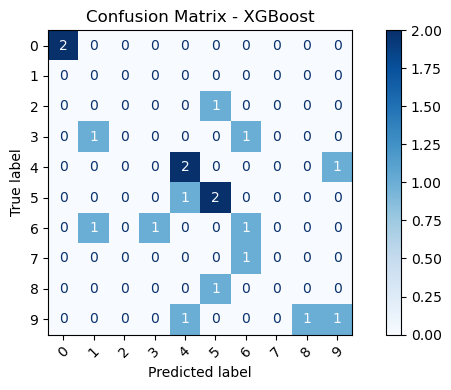

In [65]:
final_pred = final_voting_clf.predict(X_test)

#print("사용된 파라미터")
#print(final_voting_clf.get_params())

print("\n📋 [최종 Classification Report]")
print(classification_report(y_test, final_pred))

cm = confusion_matrix(y_test, final_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(7, 4))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - XGBoost")
plt.tight_layout()
plt.show()


🔁 [5-Fold 교차검증 결과]
 - Fold 1 Accuracy: 0.3333
 - Fold 2 Accuracy: 0.4667
 - Fold 3 Accuracy: 0.3333
 - Fold 4 Accuracy: 0.6000
 - Fold 5 Accuracy: 0.3571
📊 평균 교차검증 정확도: 0.4181 ± 0.1035

📋 [최종 Soft Voting 모델] Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         2
           4       0.50      0.67      0.57         3
           5       0.50      0.67      0.57         3
           6       0.33      0.33      0.33         3
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.50      0.33      0.40         3

    accuracy                           0.42        19
   macro avg       0.28      0.30      0.29        19
weighted avg       0.39      0.42      0.40        19



<Figure size 800x600 with 0 Axes>

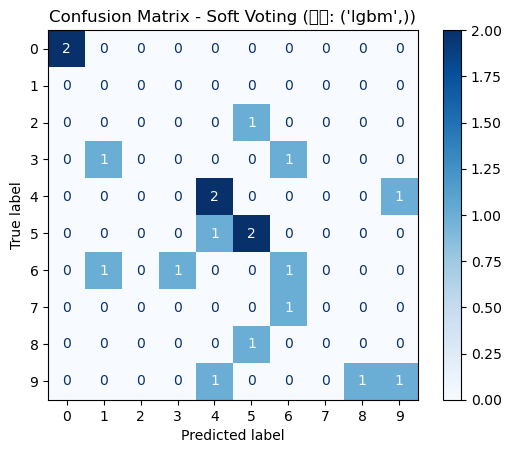

In [68]:
cv_scores = cross_val_score(final_voting_clf, X_train, y_train, cv=5, scoring='accuracy')
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

print("\n🔁 [5-Fold 교차검증 결과]")
for i, score in enumerate(cv_scores, 1):
    print(f" - Fold {i} Accuracy: {score:.4f}")
print(f"📊 평균 교차검증 정확도: {cv_mean:.4f} ± {cv_std:.4f}")

# 테스트셋 예측
voting_pred = final_voting_clf.predict(X_test)

# classification_report 출력
print("\n📋 [최종 Soft Voting 모델] Classification Report:")
print(classification_report(y_test, voting_pred))

# 혼동행렬 시각화
cm = confusion_matrix(y_test, voting_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_voting_clf.classes_)

plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title(f'Confusion Matrix - Soft Voting (조합: {best_combo})')
plt.show()

In [71]:
# 학습 정확도
y_train_pred = final_voting_clf.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)

# 테스트 정확도
test_acc = accuracy_score(y_test, y_pred)

print("\n과적합 확인:")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy : {test_acc:.4f}")

# 과적합 경고 출력
gap = train_acc - test_acc
print(f'학습 정확도와 테스트 정확도의 차이: {gap:.4f}')
if gap > 0.1:
    print(f"\n과적합 경고: 학습 정확도와 테스트 정확도 차이가 {gap:.4f}입니다.")
else:
    print("\n과적합 문제 없음 (적절한 일반화 수준)")


과적합 확인:
Train Accuracy: 0.9730
Test Accuracy : 0.2632
학습 정확도와 테스트 정확도의 차이: 0.7098

과적합 경고: 학습 정확도와 테스트 정확도 차이가 0.7098입니다.


🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.81      0.76        16
           1       0.70      0.58      0.64        12

    accuracy                           0.71        28
   macro avg       0.71      0.70      0.70        28
weighted avg       0.71      0.71      0.71        28

📊 Confusion Matrix:


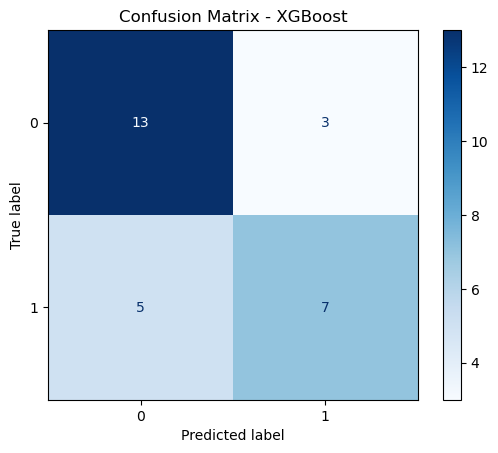


✅ 5-Fold 교차검증 정확도 평균: 0.6769 ± 0.0897

📈 Train Accuracy: 0.9385
📉 Test Accuracy : 0.7143
🔍 학습 정확도와 테스트 정확도의 차이: 0.2242


In [74]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# ===== 1. 데이터 불러오기 =====
df = pd.read_csv('cluster_3_mapped_V2.csv')
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
df = df.sort_values(by=['VSL_ID', 'PORT_NAME', 'TIMESTAMP']).reset_index(drop=True)

# ===== 2. 출발 5시간 시점 데이터 추출 =====
rows_5h = []
for (vsl_id, port), group in df.groupby(['VSL_ID', 'PORT_NAME']):
    group = group.sort_values('TIMESTAMP')
    if len(group) >= 30:  # 10분 단위 30개 = 5시간
        row_5h = group.iloc[29]
        rows_5h.append(row_5h)

df_5h = pd.DataFrame(rows_5h).dropna(subset=["LAT", "LON", "COG", "HEADING"])

# ===== 3. 특성과 타겟 분리 =====
# PORT_NAME 기준으로 라벨 인코딩
le = LabelEncoder()
df_5h['CLUSTER_2'] = le.fit_transform(df_5h['PORT_CLUSTER'])
#df['CLUSTER_2'].value_counts()

features = ["LAT", "LON", "COG", "HEADING"]
X = df_5h[features].values
y = df_5h["CLUSTER_2"].values

# ===== 4. 학습/테스트 분리 =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

np.save("datasets/X_train_c3_14hours.npy", X_train)
np.save("datasets/X_test_c3_14hours.npy", X_test)
np.save("datasets/y_train_c3_14hours.npy", y_train)
np.save("datasets/y_test_c3_14hours.npy", y_test)

# ===== 5. 모델 정의 (과적합 완화 설정) =====
model = XGBClassifier(
    max_depth=3,           # 과적합 방지용 depth 제한
    n_estimators=100,      # 트리 개수 줄이기
    subsample=0.8,         # 데이터 샘플 비율
    colsample_bytree=0.8,  # 특성 샘플 비율
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

# ===== 6. 모델 학습 =====
model.fit(X_train, y_train)

# ===== 7. 예측 및 평가 =====
y_pred = model.predict(X_test)

print("🔍 Classification Report:")
print(classification_report(y_test, y_pred))

print("📊 Confusion Matrix:")
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(cmap='Blues')
plt.title("Confusion Matrix - XGBoost")
plt.show()

# ===== 8. 교차검증 =====
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print(f"\n✅ 5-Fold 교차검증 정확도 평균: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# ===== 9. 과적합 여부 확인 =====
train_acc = accuracy_score(y_train, model.predict(X_train))
test_acc = accuracy_score(y_test, y_pred)
print(f"\n📈 Train Accuracy: {train_acc:.4f}")
print(f"📉 Test Accuracy : {test_acc:.4f}")
print(f"🔍 학습 정확도와 테스트 정확도의 차이: {round(train_acc - test_acc, 4)}")


🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.81      0.74        16
           1       0.67      0.50      0.57        12

    accuracy                           0.68        28
   macro avg       0.68      0.66      0.66        28
weighted avg       0.68      0.68      0.67        28

📊 Confusion Matrix:


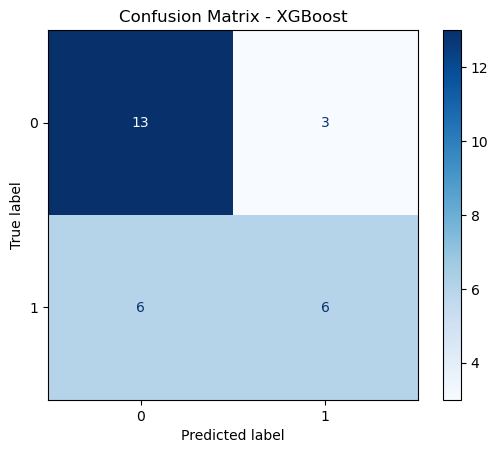


✅ 5-Fold 교차검증 정확도 평균: 0.7385 ± 0.0784

📈 Train Accuracy: 0.7846
📉 Test Accuracy : 0.6786
🔍 학습 정확도와 테스트 정확도의 차이: 0.106


In [97]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from xgboost.callback import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

# ===== 1. 데이터 불러오기 =====
df = pd.read_csv('cluster_3_mapped_V2.csv')
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
df = df.sort_values(by=['VSL_ID', 'PORT_NAME', 'TIMESTAMP']).reset_index(drop=True)

# ===== 2. 출발 5시간 시점 데이터 추출 =====
rows_5h = []
for (vsl_id, port), group in df.groupby(['VSL_ID', 'PORT_NAME']):
    group = group.sort_values('TIMESTAMP')
    if len(group) >= 30:  # 10분 단위 30개 = 5시간
        row_5h = group.iloc[29]
        rows_5h.append(row_5h)

df_5h = pd.DataFrame(rows_5h).dropna(subset=["LAT", "LON", "COG", "HEADING"])

# ===== 3. 특성과 타겟 분리 =====
le = LabelEncoder()
df_5h['CLUSTER_2'] = le.fit_transform(df_5h['PORT_CLUSTER'])  # CLUSTER_2 = 정수 인코딩된 PORT_CLUSTER

features = ["LAT", "LON", "COG", "HEADING"]
X = df_5h[features].values
y = df_5h["CLUSTER_2"].values

# ===== 4. 학습/테스트 분리 =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

np.save("datasets/X_train_c3_14hours.npy", X_train)
np.save("datasets/X_test_c3_14hours.npy", X_test)
np.save("datasets/y_train_c3_14hours.npy", y_train)
np.save("datasets/y_test_c3_14hours.npy", y_test)

# ===== 5. 모델 정의 (과적합 방지 포함) =====
model = XGBClassifier(
    max_depth=3,
    n_estimators=300,            # 트리 개수 증가 (early stopping 적용 시 필요)
    learning_rate=0.05,          # 학습률 낮춤
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.5,               # L1 정규화
    reg_lambda=1.5,              # L2 정규화
    min_child_weight=5,          # 작은 노드 억제
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

# ===== 6. 모델 학습 (Early Stopping 적용) =====
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

model.fit(X_train, y_train)

# ===== 7. 예측 및 평가 =====
y_pred = model.predict(X_test)

print("🔍 Classification Report:")
print(classification_report(y_test, y_pred))

print("📊 Confusion Matrix:")
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(cmap='Blues')
plt.title("Confusion Matrix - XGBoost")
plt.show()

# ===== 8. 교차검증 =====
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print(f"\n✅ 5-Fold 교차검증 정확도 평균: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# ===== 9. 과적합 여부 확인 =====
train_acc = accuracy_score(y_train, model.predict(X_train))
test_acc = accuracy_score(y_test, y_pred)
print(f"\n📈 Train Accuracy: {train_acc:.4f}")
print(f"📉 Test Accuracy : {test_acc:.4f}")
print(f"🔍 학습 정확도와 테스트 정확도의 차이: {round(train_acc - test_acc, 4)}")


In [99]:
import joblib
import os

# 모델 저장
joblib.dump(voting_clf, 'model/port_c3_14hours.joblib')

# 인코더 저장
joblib.dump(le, 'model/encoder_c3_14hours.joblib')

print("✅ 모델과 인코더가 각각 저장되었습니다.")

✅ 모델과 인코더가 각각 저장되었습니다.


# 6번 군집

# 그마마

📊 [Logistic Regression 성능]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.40      0.50      0.44         4
           2       0.57      0.44      0.50         9
           3       0.00      0.00      0.00         1
           4       1.00      0.33      0.50         3

    accuracy                           0.39        18
   macro avg       0.39      0.26      0.29        18
weighted avg       0.54      0.39      0.43        18


📊 [XGBoost 성능]
              precision    recall  f1-score   support

           0       0.25      1.00      0.40         1
           1       0.33      0.25      0.29         4
           2       0.60      0.67      0.63         9
           3       0.00      0.00      0.00         1
           4       1.00      0.33      0.50         3

    accuracy                           0.50        18
   macro avg       0.44      0.45      0.36        18
weighted avg       0.55      0.50 

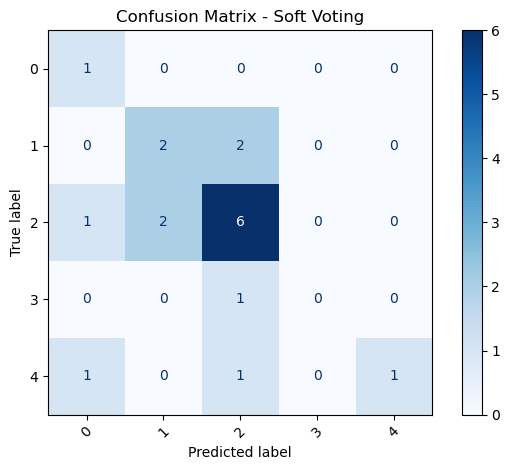

In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings("ignore")

# ===== 1. 데이터 불러오기 및 전처리 =====
df = pd.read_csv('./dataset/cluster1_6.csv')
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
df = df.sort_values(by=['VSL_ID', 'PORT_NAME', 'TIMESTAMP']).reset_index(drop=True)

# ===== 2. 14시간 시점 추출 (10분 단위 → 84개 row) =====
rows_14h = []
for (vsl_id, port), group in df.groupby(['VSL_ID', 'PORT_NAME']):
    if len(group) >= 84:
        rows_14h.append(group.iloc[83])

df_14h = pd.DataFrame(rows_14h).reset_index(drop=True)

# ===== 3. 라벨 인코딩 =====
le = LabelEncoder()
df_14h['CLUSTER_2'] = le.fit_transform(df_14h['PORT_NAME'])

# ===== 4. 학습/테스트 분리 =====
features = ['LAT', 'LON', 'COG', 'HEADING']
X = df_14h[features]
y = df_14h['CLUSTER_2']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# ===== 5. 오버샘플링 (Train 데이터만) =====
train_df = pd.concat([X_train, y_train], axis=1)
target = 'CLUSTER_2'
min_target = 15
oversampled_rows = []

for label in train_df[target].unique():
    subset = train_df[train_df[target] == label]
    if len(subset) < min_target:
        upsampled = resample(subset, replace=True, n_samples=min_target, random_state=42)
        oversampled_rows.append(upsampled)
    else:
        oversampled_rows.append(subset)

train_oversampled = pd.concat(oversampled_rows).reset_index(drop=True)
X_train = train_oversampled[features]
y_train = train_oversampled[target]

np.save("datasets/X_train_c6_14hours.npy", X_train)
np.save("datasets/X_test_c6_14hours.npy", X_test)
np.save("datasets/y_train_c6_14hours.npy", y_train)
np.save("datasets/y_test_c6_14hours.npy", y_test)

# ===== 6. 모델 정의 및 학습 =====

# Logistic Regression
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

# XGBoost
xgb_model = XGBClassifier(
    max_depth=3,
    learning_rate=0.05,
    n_estimators=100,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# ===== 7. 평가 =====
print("📊 [Logistic Regression 성능]")
print(classification_report(y_test, lr_pred))

print("\n📊 [XGBoost 성능]")
print(classification_report(y_test, xgb_pred))

from sklearn.ensemble import VotingClassifier

# ===== 1. Soft Voting 앙상블 정의 =====
voting_clf = VotingClassifier(
    estimators=[
        ('lr', lr_model),
        ('xgb', xgb_model)
    ],
    voting='soft'
)

# ===== 2. 학습 및 예측 =====
voting_clf.fit(X_train, y_train)
voting_pred = voting_clf.predict(X_test)

# ===== 3. 성능 평가 =====
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("\n📊 [Soft Voting 앙상블 성능]")
print(classification_report(y_test, voting_pred))

# 정확도 출력
acc = accuracy_score(y_test, voting_pred)
print(f"✅ Accuracy: {acc:.4f}")

# 혼동 행렬 시각화
cm = confusion_matrix(y_test, voting_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Soft Voting")
plt.tight_layout()
plt.show()

In [38]:
# PORT_NAME ↔ 숫자 라벨 매핑 확인
label_mapping = pd.DataFrame({
    "Encoded_Label": range(len(le.classes_)),
    "PORT_NAME": le.classes_
})

print(label_mapping)


   Encoded_Label PORT_NAME
0              0     CNDAG
1              1     CNLYG
2              2     CNQDG
3              3     CNRZH
4              4     CNTXG


In [29]:
import joblib
import os

# 모델 저장
joblib.dump(voting_clf, 'model/port_c6_14hours.joblib')

# 인코더 저장
joblib.dump(le, 'model/encoder_c6_14hours.joblib')

print("✅ 모델과 인코더가 각각 저장되었습니다.")

✅ 모델과 인코더가 각각 저장되었습니다.
